## Anomaly Detection for NYC Taxi & Limousine Data

In [68]:
import numpy as np
import pandas as pd
import os
import subprocess
from shapely.geometry import Point
from datetime import datetime
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest

from itertools import compress

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
proj_folder = os.getcwd()

## TLC anomaly detection

## Notes 4-22-17
Next steps:
1. would love to look at different areas of the city and see where the anomalies relative to those places
i.e. taxi trips to/from coney island would be interesting / or around MSG - "concert superstorm?"

In [5]:
### read in data for 2016
columns = ['passenger_count', 'trip_distance', 'fare_amount', \
                     'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime']
tlc_df_raw_total = pd.DataFrame(columns = columns)
for i in range(1,4):
    tlc_df_raw = pd.read_csv(proj_folder + '/data/tlc_yellow_2016_' + str(i) + '.csv', usecols=['passenger_count', \
                    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)

In [6]:
len(tlc_df_raw_total)

34499859

In [7]:
tlc_df_raw_total['tpep_pickup_datetime'] = pd.to_datetime(tlc_df_raw_total['tpep_pickup_datetime'])
tlc_df_raw_total['tpep_dropoff_datetime'] = pd.to_datetime(tlc_df_raw_total['tpep_dropoff_datetime'])
tlc_df_raw_total.head()

,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,0.5,7.5,0.5,2.0,0.0,8.8,2016-01-01,2016-01-01,1.10
1,0.5,18.0,0.5,5.0,0.0,19.3,2016-01-01,2016-01-01,4.90
2,0.5,33.0,0.5,1.0,0.0,34.3,2016-01-01,2016-01-01,10.54
3,0.0,16.5,0.5,1.0,0.0,17.3,2016-01-01,2016-01-01,4.75
4,0.0,8.0,0.5,3.0,0.0,8.8,2016-01-01,2016-01-01,1.76


In [8]:
#CANNOT GET THIS TRIP DURATION TO WORK - MOVING ON FOR NOW
#tlc_df['trip_duration'] = pd.Timedelta(tlc_df['tpep_dropoff_datetime_2'] - tlc_df['tpep_pickup_datetime']).seconds / 3600.0
#tlc_df['trip_speed'] = tlc_df.trip_distance / tlc_df.trip_duration

## Clean the data - 
drop all the unreasonable trip entries, such as those that have trip distance in the millions of miles

In [38]:
tlc_df_raw_total.sort(['trip_distance'], ascending=False).head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date
30629016,1.0,2.5,0.5,1.0,0.0,4.3,2016-03-07 20:16:21,2016-03-07 19:57:50,19072628.8,2016-03-07
14870695,0.0,2.5,0.5,3.0,0.0,3.3,2016-02-13 09:22:00,2016-02-13 09:20:43,11658534.3,2016-02-13
32502724,0.0,9.0,0.5,2.0,0.0,9.8,2016-03-26 17:33:23,2016-03-26 17:24:14,8330083.2,2016-03-26
1027151,0.0,27.5,0.5,1.0,0.0,28.3,2016-01-04 15:27:47,2016-01-04 14:56:45,8000010.0,2016-01-04
15365256,0.0,0.0,0.0,1.0,0.0,0.3,2016-02-13 15:00:58,2016-02-13 13:25:43,5361519.7,2016-02-13


In [39]:
tlc_df_raw_total.sort(['total_amount'], ascending=False).head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date
31216497,65.53,429496.72,0.00,1.0,0.0,429562.25,2016-03-11 00:18:58,2016-03-10 22:59:51,0.0,2016-03-10
18747027,20.55,154810.43,1.16,1.0,0.0,154832.14,2016-02-23 15:03:09,2016-02-23 14:26:33,298914.2,2016-02-23
15958592,63.99,153231.93,0.00,1.0,0.0,153296.22,2016-02-16 18:36:33,2016-02-16 18:20:33,151694.0,2016-02-16
29029949,65.53,133065.37,0.00,3.0,0.0,133131.20,2016-03-20 23:03:04,2016-03-20 22:58:18,166331.6,2016-03-20
28810417,16.38,126348.88,1.32,2.0,0.0,126366.58,2016-03-20 12:03:29,2016-03-20 11:44:34,131091.4,2016-03-20


In [37]:
tlc_df_raw_total.sort(['tip_amount'], ascending=False).head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date
67897,0.5,5.5,0.5,2.0,998.14,1004.94,2016-01-01 01:05:54,2016-01-01 01:01:22,1.0,2016-01-01
1617570,0.0,52.0,0.5,1.0,900.00,952.80,2016-01-08 06:46:51,2016-01-08 06:46:33,0.0,2016-01-08
23571215,0.0,52.0,0.5,1.0,850.00,902.80,2016-03-03 22:15:52,2016-03-03 22:11:00,0.7,2016-03-03
5274108,0.0,52.0,0.5,1.0,800.00,852.80,2016-01-15 06:30:39,2016-01-15 06:30:31,0.0,2016-01-15
180698,0.0,52.0,0.5,1.0,800.00,852.80,2016-01-01 06:40:16,2016-01-01 06:39:44,0.0,2016-01-01


In [41]:
#only keep trips that have a positive distance less than 100 miles
tlc_df_total = tlc_df_raw_total[(tlc_df_raw_total.trip_distance > 0) & (tlc_df_raw_total.trip_distance < 100)]

#only keep trips that have a positive fare amount less than $500
tlc_df_total = tlc_df_total[(tlc_df_total.fare_amount > 0) & (tlc_df_total.fare_amount < 500)]

In [43]:
len(tlc_df_total) * 1.0 / len(tlc_df_raw_total)

0.9936390464668275

In [44]:
#count the number of taxi trips each day
tlc_df_total['taxi_date'] = tlc_df_total['tpep_pickup_datetime'].dt.date
tlc_df_day_count = tlc_df_total.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_day_count.columns = ['taxi_date', 'taxi_trip_count']

In [53]:
#take the mean of the taxi stats each day
tlc_df_stat_agg = tlc_df_total.groupby(['taxi_date'], as_index=False).mean()
tlc_df_stat_agg.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance
0,2016-01-01,0.270617,12.795289,0.498092,1.795093,1.441512,15.569496,3.292646
1,2016-01-02,0.198105,12.392116,0.498403,1.777977,1.459314,15.139841,3.082059
2,2016-01-03,0.200098,12.997669,0.498177,1.739239,1.650988,16.022176,3.425719
3,2016-01-04,0.374877,12.159065,0.498728,1.649450,1.634711,15.314045,3.031284
4,2016-01-05,0.356747,11.954732,0.498906,1.635951,1.649986,15.040607,2.830233


In [54]:
tlc_df_by_day = tlc_df_stat_agg.merge(tlc_df_day_count, on='taxi_date')
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,taxi_trip_count
0,2016-01-01,0.270617,12.795289,0.498092,1.795093,1.441512,15.569496,3.292646,342467
1,2016-01-02,0.198105,12.392116,0.498403,1.777977,1.459314,15.139841,3.082059,310850
2,2016-01-03,0.200098,12.997669,0.498177,1.739239,1.650988,16.022176,3.425719,300678
3,2016-01-04,0.374877,12.159065,0.498728,1.649450,1.634711,15.314045,3.031284,314058
4,2016-01-05,0.356747,11.954732,0.498906,1.635951,1.649986,15.040607,2.830233,341089


In [55]:
tlc_df_by_day['weekday'] = 0
for i in range(len(tlc_df_by_day)):
    tlc_df_by_day['weekday'].iloc[i] = tlc_df_by_day.taxi_date.iloc[i].weekday()

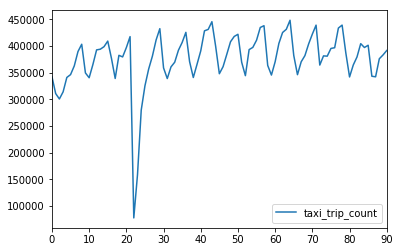

In [56]:
tlc_df_by_day[['taxi_date', 'taxi_trip_count']].plot()

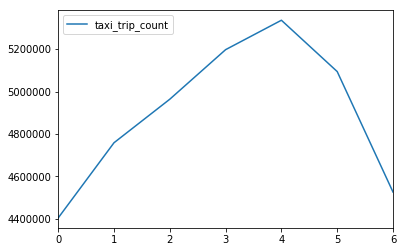

In [57]:
tlc_df_by_day_agg = tlc_df_by_day.groupby(['weekday'], as_index=False).sum()
tlc_df_by_day_agg[['taxi_trip_count']].plot()

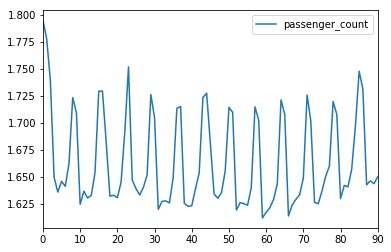

In [58]:
tlc_df_by_day[['taxi_date', 'passenger_count']].plot()

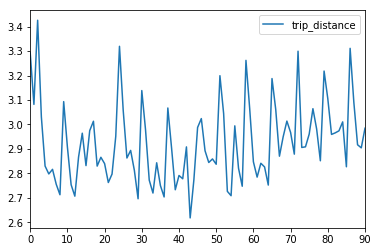

In [59]:
tlc_df_by_day[['taxi_date', 'trip_distance']].plot()

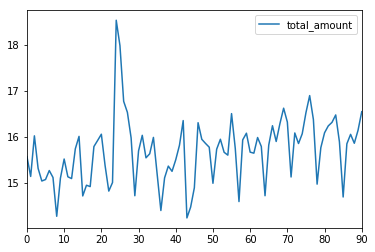

In [60]:
tlc_df_by_day[['taxi_date', 'total_amount']].plot()

In [61]:
X = tlc_df_by_day[['passenger_count', 'trip_distance' ,'total_amount', 'taxi_trip_count']]
X.head(2)

,passenger_count,trip_distance,total_amount,taxi_trip_count
0,1.795093,3.292646,15.569496,342467
1,1.777977,3.082059,15.139841,310850


## Clustering Anomaly Detection

### Gaussian Mixture Model Anomaly Detection

In [62]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.839684098278
For n_clusters =3, the average silhouette_score is :0.568602876405
For n_clusters =4, the average silhouette_score is :0.544348877186
For n_clusters =5, the average silhouette_score is :0.587465319958
For n_clusters =6, the average silhouette_score is :0.605560433797
For n_clusters =7, the average silhouette_score is :0.593835521857
For n_clusters =8, the average silhouette_score is :0.595763037962


In [63]:
GM=GaussianMixture(n_components=2, random_state=324)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=324, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

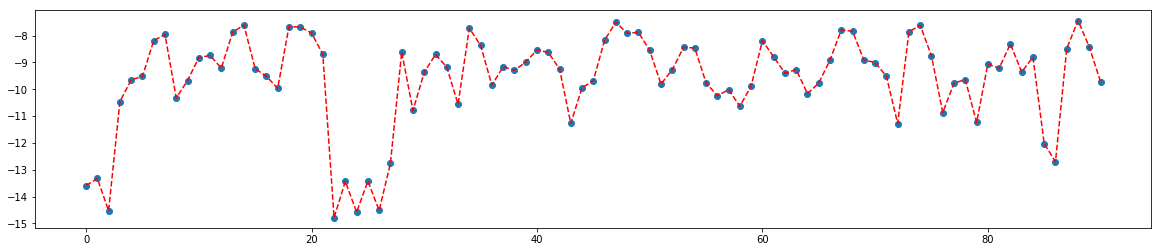

In [64]:
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.plot(GM.score_samples(X),"r--")
plt.show()

## Isolation Anomaly Detection

### Isolation Forest Anomaly Detection

In [69]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/iforest.py:184: UserWarning: max_samples (100) is greater than the total number of samples (63). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


In [70]:
tlc_df_by_day['decision_function'] = clf.decision_function(X)

In [72]:
tlc_df_by_day.sort_values(by='decision_function').head(10)

,taxi_date,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,taxi_trip_count,weekday,decision_function
24,2016-01-25,0.379404,14.854335,0.498136,1.647179,2.086684,18.534021,3.319237,279805,0,-0.136040
22,2016-01-23,0.362535,11.875412,0.498546,1.691393,1.680846,14.821589,2.797509,77354,5,-0.124463
23,2016-01-24,0.149384,12.179742,0.498538,1.751895,1.624971,15.007358,2.951654,158675,6,-0.063665
2,2016-01-03,0.200098,12.997669,0.498177,1.739239,1.650988,16.022176,3.425719,300678,6,-0.061439
0,2016-01-01,0.270617,12.795289,0.498092,1.795093,1.441512,15.569496,3.292646,342467,4,-0.055074
43,2016-02-13,0.198109,11.556715,0.498945,1.723480,1.513157,14.238487,2.618400,445761,5,-0.039224
1,2016-01-02,0.198105,12.392116,0.498403,1.777977,1.459314,15.139841,3.082059,310850,5,-0.033962
25,2016-01-26,0.368764,14.366871,0.498617,1.639194,2.084838,17.982999,3.057893,325441,1,-0.030700
86,2016-03-27,0.202972,12.879512,0.498490,1.731464,1.633937,15.849132,3.310940,343351,6,-0.019898
36,2016-02-06,0.214063,11.658167,0.499023,1.713525,1.557601,14.399616,2.704059,425768,5,0.014031
